<h2>DESGW Observation Preparation</h2>

This is a notebook which encompasses all the preparation required before observing for an event which has been triggered. To do everything in the notebook you're going to need the latest skymap from the event in question and an exposure list from <code>gw_workflow</code>. You can get the skymap from the GraceDB page for the event, and the <code>exposures.list</code> file either from an existing <code>gw_workflow</code> directory or by running <code>getExposureInfo.sh</code> in <code>gw_workflow</code>.

The required packages for this notebook are numpy, healpy, pandas, ligo.skymap, matplotlib, astropy

In [1]:
import numpy as np
import healpy as hp
import pandas as pd
import ligo.skymap.plot
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.patches import Polygon
from astropy.coordinates.representation import UnitSphericalRepresentation
from astropy.coordinates.matrix_utilities import rotation_matrix
from astropy import units as u
from glob import glob
import json

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 7})

superevent = 'S240915b'
dpi = 150

In [2]:
def get_ccd_corners(ccd):
    with open('zeroed_corners.list', 'r') as file:
        header = file.readline().strip().split(',')
        ccd_index = header.index('CCD')
        ccd = f'{ccd}.0'
        corner1_ra_index = header.index('Corner 1 Ra')
        corner1_dec_index = header.index('Corner 1 Dec')
        corner2_ra_index = header.index('Corner 2 Ra')
        corner2_dec_index = header.index('Corner 2 Dec')
        corner3_ra_index = header.index('Corner 3 Ra')
        corner3_dec_index = header.index('Corner 3 Dec')
        corner4_ra_index = header.index('Corner 4 Ra')
        corner4_dec_index = header.index('Corner 4 Dec')
        for line in file:
            columns = line.strip().split(',')
            if columns[ccd_index] == ccd:
                value = 1
                corner1 = [value*float(columns[corner1_ra_index]), value*float(columns[corner1_dec_index])]
                corner2 = [value*float(columns[corner2_ra_index]), value*float(columns[corner2_dec_index])]
                corner3 = [value*float(columns[corner3_ra_index]), value*float(columns[corner3_dec_index])]
                corner4 = [value*float(columns[corner4_ra_index]), value*float(columns[corner4_dec_index])]
                return [corner1, corner2, corner3, corner4]

def _rotate_polygon(lon, lat, lon0, lat0):
    polygon = UnitSphericalRepresentation(lon=lon, lat=lat)
    m1 = rotation_matrix(lat0, axis='y')
    m2 = rotation_matrix(-lon0, axis='z')
    transform_matrix = m2 @ m1
    polygon = polygon.to_cartesian()
    polygon = polygon.transform(transform_matrix)
    polygon = UnitSphericalRepresentation.from_cartesian(polygon)
    return polygon.lon, polygon.lat

class SphericalCCD(Polygon):
    # An adaptation of astropy.visualization.wcsaxes.SphericalCircle for DES CCD footprint
    # Avoids distortion near the poles and preserves solid angle
    # https://astropy-astrofrog.readthedocs.io/en/latest/api/astropy.visualization.wcsaxes.SphericalCircle.html#astropy.visualization.wcsaxes.SphericalCircle
    def __init__(self, center, ccd, vertex_unit=u.degree, **kwargs):
        corners = get_ccd_corners(ccd)
        x, y = zip(*corners)
        x = np.append(np.array(x), x[0])
        y = np.append(np.array(y), y[0])
        lon, lat = _rotate_polygon(x*u.deg, y*u.deg, center[0], center[1])
        lon = lon.to_value(vertex_unit)
        lat = lat.to_value(vertex_unit)
        vertices = np.array([lon, lat]).transpose()
        super().__init__(vertices, **kwargs)

def plot_footprint(ax, center):
    ccd_numbers = np.arange(1, 63)
    ixs = np.where((ccd_numbers != 2) & (ccd_numbers != 61) )
    ccd_numbers = ccd_numbers[ixs]
    for ccd in ccd_numbers:
        p = SphericalCCD(center, ccd, transform=ax.get_transform('world'), linewidth=0.5, fill=False, edgecolor='C0')
        ax.add_patch(p)

<h3>Loading the skymap</h3>
The skymap from LVK needs to be flattened first. If that has not been done, then uncomment this line and do that first.

Once the skymap has been flattened, it can be plotted. Here I find the contour levels and then plot them over a rudimentary map of the galatic plane that I made from GLADE+.

In [3]:
#!ligo-skymap-flatten skymap_{supervent}.fits skymap_{superevent}_flatten.fits

In [4]:
galplane = hp.read_map('glade_galplane_footprint.fits')
prob, distmu, distsig, distnorm = hp.read_map(f'skymap_{superevent}_flatten.fits', field=[0, 1, 2, 3])

In [5]:
sorted_probs = np.flipud(np.sort(prob))
levels = np.cumsum(sorted_probs)
index90 = np.searchsorted(levels, 0.9)
index50 = np.searchsorted(levels, 0.5)

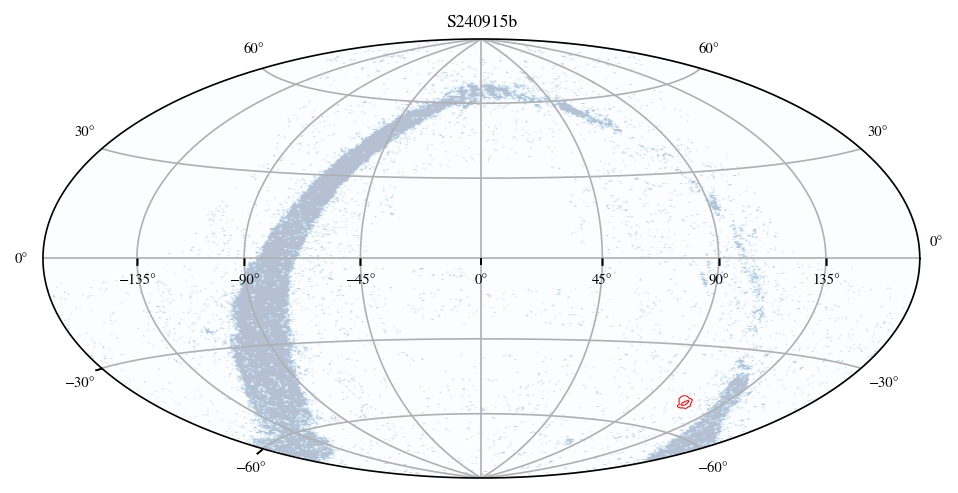

In [6]:
fig = plt.figure(dpi=dpi)
ax = plt.subplot(projection='geo aitoff')
ax.grid()

ax.imshow_hpx(galplane, cmap='Blues', alpha=0.3)
ax.contour_hpx(prob, smooth=0.1*u.deg, levels=[sorted_probs[index90], sorted_probs[index50]], linewidths=0.5, colors='r')

ax.set_title(superevent)
fig.tight_layout()

<h3>Plotting the Skymap</h3>
Find the coordinates of highest probability and adjust the center and radius parameters here to match. This just frames the event region.

In [7]:
center = '113.2d -49.75d'
radius = '5 deg'

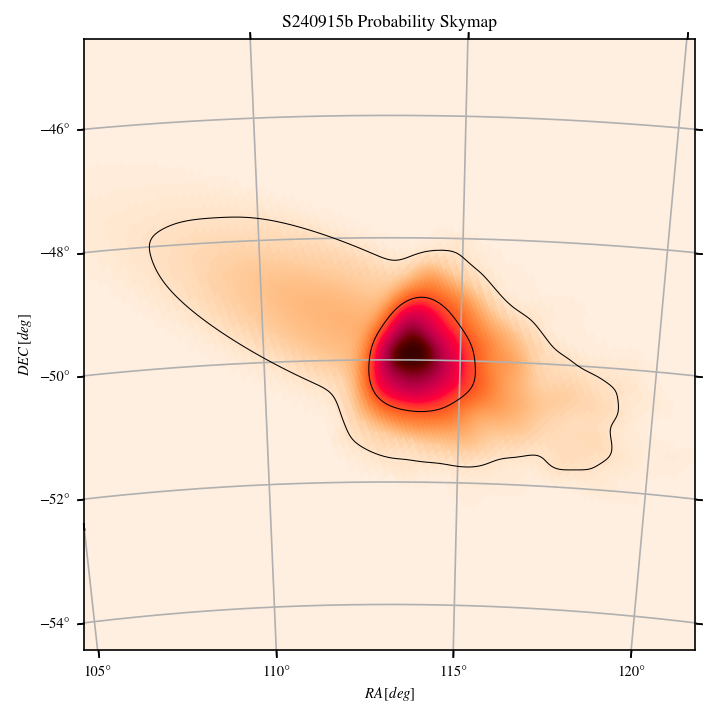

In [8]:
fig = plt.figure(dpi=dpi)
ax = plt.subplot(projection='geo degrees zoom', center=center, radius=radius)
ax.grid()
ax.set_xlabel(r"$RA \, [deg]$")
ax.set_ylabel(r"$DEC \, [deg]$")
ax.imshow_hpx(prob, cmap='cylon')
ax.contour_hpx(prob, smooth=0.1*u.deg, levels=[sorted_probs[index90], sorted_probs[index50]], colors='k', linestyles='solid', linewidths=0.5)

ax.set_title(f'{superevent} Probability Skymap')
fig.tight_layout()

<h3>Make the Observing Plan</h3>

Traditionally, for a BNS event, Main Injector should run strategy and produce a json with the observing plan. If this happens, you will likely need to change some of the json elements later as well. However, if Main Injector doesn't make a json for whatever reason, you're going to need to do it manually.


You can do this by cloning Main Injector into a separate directory and making a python script to run OneRing manually. I have an example line below that you can use. Tf this also doesn't work then you will have to define pointings manually and adjust them by plotting them.

In any case it is a good idea to verify what the plan is doing and perhaps confer with the other team members about reducing or adding pointings

In [9]:
#lp, dp, inner, sumprobinhex, centers = OneRing.run_or('skymap_S240915b_flatten.fits', 0.96, 0.50, 'ii', [90, 90], [90, 90], 60568, [1, 1], resolution=64, jsonFilename='manual.json')

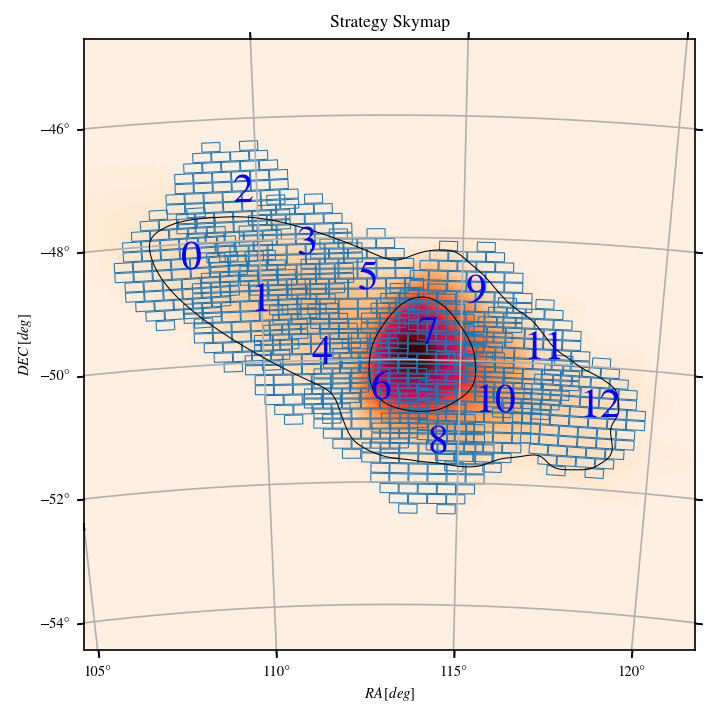

In [14]:
# This is a manually created obs plan that I made by hand. It lets me pack the pointings better to be more efficient

hex_loc = np.array([
    [108.05, -48.4],
    [109.7, -49.15],
    [109.4, -47.35],
    [110.9, -48.25],
    [111.2, -50.05],
    [112.4, -48.83],
    [112.7, -50.63],#    [113.6, -47.93],
    [113.9, -49.73],#    [112.48, -48.75],#    [112.78, -50.55],#    [113.98, -49.65],#    [115.18, -48.95],#    [115.48, -50.75],
    [114.2, -51.53],
    [115.1, -49.03],
    [115.4, -50.83],
    [116.6, -49.93],#    [116.9, -51.73],
    [118.1, -50.83],
])

fig = plt.figure(dpi=dpi)
ax = plt.subplot(projection='geo degrees zoom', center='113.2d -49.75d', radius='5 deg')
ax.grid()
ax.set_xlabel(r"$RA \, [deg]$")
ax.set_ylabel(r"$DEC \, [deg]$")

ax.imshow_hpx(prob, cmap='cylon')
ax.contour_hpx(prob, smooth=0.1*u.deg, levels=[sorted_probs[index90], sorted_probs[index50]], colors='k', linestyles='solid', linewidths=0.5)

for i in range(len(hex_loc)):
    plot_footprint(ax, (hex_loc[i,0]*u.deg, hex_loc[i,1]*u.deg))
    ax.text(hex_loc[i,0], hex_loc[i,1], i, color='b', transform=ax.get_transform('world'), fontsize=20)

ax.set_title('Strategy Skymap')
fig.tight_layout()

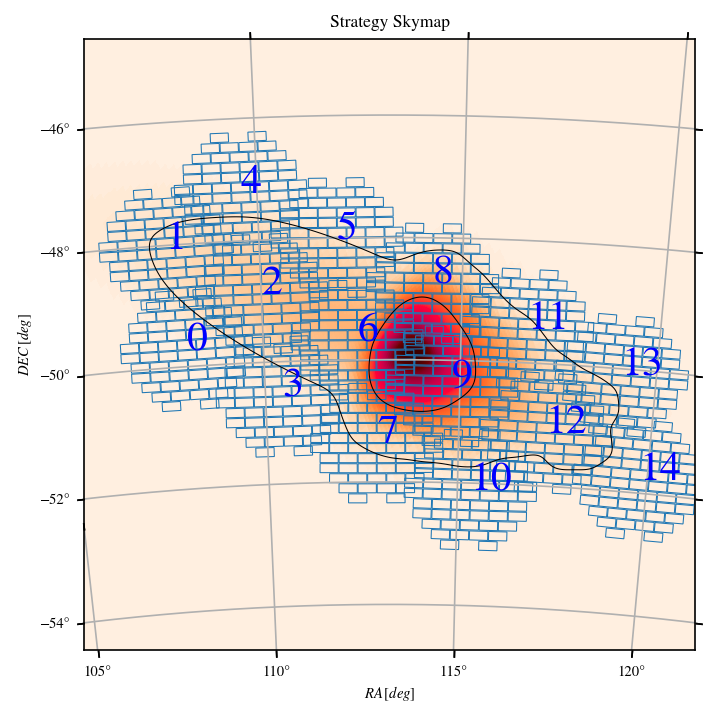

In [31]:
# This is an obs plan from OneRing. OneRing always patterns the pointings like this across the whole sky.
# It's efficient at filling space but may not be the best strategy if the area is small.

with open('S240915b_obsplan_onering.json', 'r') as jsonfile:
    hexes = json.load(jsonfile)

hex_coords = np.empty((len(hexes),2), dtype='object')
for i in range(len(hexes)):
    hex_coords[i,0] = hexes[i]['RA']
    hex_coords[i,1] = hexes[i]['dec']

fig = plt.figure(dpi=dpi)
ax = plt.subplot(projection='geo degrees zoom', center='113.2d -49.75d', radius='5 deg')
ax.grid()
ax.set_xlabel(r"$RA \, [deg]$")
ax.set_ylabel(r"$DEC \, [deg]$")

ax.imshow_hpx(prob, cmap='cylon')
ax.contour_hpx(prob, smooth=0.1*u.deg, levels=[sorted_probs[index90], sorted_probs[index50]], colors='k', linestyles='solid', linewidths=0.5)

for i in range(len(hex_coords)):
    plot_footprint(ax, (hex_coords[i,0]*u.deg, hex_coords[i,1]*u.deg))
    ax.text(hex_coords[i,0], hex_coords[i,1], i, color='b', transform=ax.get_transform('world'), fontsize=20)

ax.set_title('Strategy Skymap')
fig.tight_layout()

<h3>Making the JSON file</h3>
I've found that the json files produced from OneRing don't have all the needed information. Here I have the pointing coordinates from above with explicitly defined metadata and passbands. They get dumped into a json file together. This is the file that should be sent to CTIO for observing.

In [15]:
json_list = []

for i in range(len(hex_loc)):
    hex_dict = {'expType': 'object', 'object': 'LIGO/Virgo', 'expTime': 90, 'wait': 'False', 'program': 'des gw', 'propid': '2024B-305328', 'HEX': -999, 'filter': 'g'}
    hex_dict['RA'] = hex_loc[i,0]
    hex_dict['dec'] = hex_loc[i,1]
    hex_dict['comment'] = f'LIGO/Virgo strategy bright on S240915b: image {i}, filter g, pass 1'
    json_list.append(hex_dict.copy())

for i in range(len(hex_loc)):
    hex_dict = {'expType': 'object', 'object': 'LIGO/Virgo', 'expTime': 90, 'wait': 'False', 'program': 'des gw', 'propid': '2024B-305328', 'HEX': -999, 'filter': 'r'}
    hex_dict['RA'] = hex_loc[i,0]
    hex_dict['dec'] = hex_loc[i,1]
    hex_dict['comment'] = f'LIGO/Virgo strategy bright on S240915b: image {i}, filter r, pass 1'
    json_list.append(hex_dict.copy())
    
for i in range(len(hex_loc)):
    hex_dict = {'expType': 'object', 'object': 'LIGO/Virgo', 'expTime': 90, 'wait': 'False', 'program': 'des gw', 'propid': '2024B-305328', 'HEX': -999, 'filter': 'i'}
    hex_dict['RA'] = hex_loc[i,0]
    hex_dict['dec'] = hex_loc[i,1]
    hex_dict['comment'] = f'LIGO/Virgo strategy bright on S240915b: image {i}, filter i, pass 1'
    json_list.append(hex_dict.copy())

with open('S240915b_obsplanx.json', 'w') as f:
    json.dump(json_list, f, ensure_ascii=False)

<h3>Obsplan Animation</h3>
Fun illustrative plot

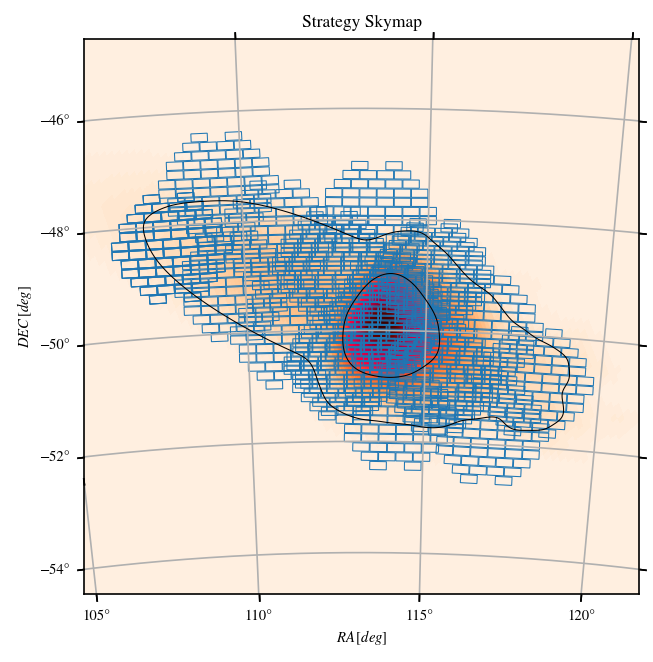

In [19]:
import matplotlib.animation
from IPython.display import HTML

fig = plt.figure(dpi=dpi)
ax = plt.subplot(projection='geo degrees zoom', center='113.2d -49.75d', radius='5 deg')
ax.set_xlabel(r"$RA \, [deg]$")
ax.set_ylabel(r"$DEC \, [deg]$")
ax.set_title('Strategy Skymap')
ax.grid()
ax.imshow_hpx(prob, cmap='cylon')
ax.contour_hpx(prob, smooth=0.1*u.deg, levels=[sorted_probs[index90], sorted_probs[index50]], colors='k', linestyles='solid', linewidths=0.5)

with open('S240915b_obsplan_extra.json', 'r') as jsonfile:
    hexes = json.load(jsonfile)

hex_coords = np.empty((len(hexes), 2), dtype='object')
for i in range(len(hexes)):
    hex_coords[i,0] = hexes[i]['RA']
    hex_coords[i,1] = hexes[i]['dec']

def animate(i):
    plot_footprint(ax, (hex_coords[i,0]*u.deg, hex_coords[i,1]*u.deg))

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=20, interval=100, repeat=False)
ani.save(filename="S240915b_obsplan_extra.gif", writer="pillow")

<h3>Finding Templates</h3>

This section is for finding and pre-processing the templates for the event. I load template information from the exposure list and find previous DECam exposures that exist in the footprint. Here I define the coordinate limits explicitly, which will need to be changed to suit needs. Aside from the band, the other criteria are hard limits. Once you get a list of template expnums, you should run <code>DAGMaker.sh</code> in <code>gw_workflow</code> for each of them. This will create a <code>desgw_pipeline_*.dag</code> file with all the templates that are chosen by DAGMaker for the region. I have some code in <code>/data/des70.a/data/desgw/O4/S240915b/gw_workflow/JobHelper/jobOverrider.ipynb</code> to parse these files and create custom dags that you can run pre-event to get the templates processed.

In [11]:
template_expnums = np.loadtxt('exposures.list', skiprows=1, usecols=[0], dtype=int)
template_nites = np.loadtxt('exposures.list', skiprows=1, usecols=[1], dtype=str)
template_ra = np.loadtxt('exposures.list', skiprows=1, usecols=[3], dtype=float)
template_dec = np.loadtxt('exposures.list', skiprows=1, usecols=[4], dtype=float)
template_band = np.loadtxt('exposures.list', skiprows=1, usecols=[5], dtype=str)

template_object = []
with open('exposures.list', 'r') as f:
    lines = f.readlines()
    for line in lines[1:]:
        template_object.append(line[111:].strip())
template_object = np.array(template_object)

In [14]:
mask = (template_expnums > 600000) & ((template_band=='g')|(template_band=='r')|(template_band=='i')) & \
    (template_ra>104) & (template_ra<120) & ((4*template_dec+template_ra)>-93) & ((5*template_dec+template_ra)<-125) & \
    (np.core.defchararray.find(template_object,'zero')==-1) & \
    (np.core.defchararray.find(template_object,'flat')==-1) & \
    (np.core.defchararray.find(template_object,'test')==-1) & \
    (np.core.defchararray.find(template_object,'junk')==-1) & \
    (np.core.defchararray.find(template_object,'bias')==-1) & \
    (np.core.defchararray.find(template_object,'supernova')==-1) & \
    (np.core.defchararray.find(template_object,'slew')==-1) & \
    (np.core.defchararray.find(template_object,'pointing')==-1) & \
    (np.core.defchararray.find(template_object,'sn')==-1) & \
    (np.core.defchararray.find(template_object,'commish')==-1)

template_expnums[mask]

array([ 733347,  733348,  733349,  733351,  733352,  733354,  733355,
        812702,  815727,  820512,  820513,  820514,  820515,  820768,
        820769,  820770,  820771,  820787,  820788,  820789,  820790,
        820791,  820792,  820831,  820832,  820833,  820834,  820849,
        820850,  820851,  820852,  821121,  821122,  821123,  821124,
        821131,  821132,  821133,  821134,  821143,  821144,  821145,
        821146,  821147,  821148,  821163,  821164,  821442,  821445,
        821446,  821449,  821450,  821451,  821458,  821459,  821460,
        821461,  821472,  821473,  821474,  821475,  821516,  821517,
        821518,  821519,  821530,  821531,  821532,  821533,  821534,
        821535,  907264,  907265,  907269,  907270,  907546,  907547,
        907549,  907550,  907552,  915397,  915699,  916542,  928986,
        928987,  930568,  930569,  931319,  931329,  931330,  941743,
        941744,  941758,  941759,  948491,  956734,  956736,  956737,
        956738,  956